In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
import PIL
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [3]:
assert torch.__version__=='1.8.1'

In [4]:
np.random.seed(0)
torch.manual_seed(0)

In [5]:
#trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True)#, transform = transform)
#testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False)#, transform = transform)

In [10]:
fashion_imgs = torch.load('MNIST_data/FashionMNIST/processed/test.pt')

In [13]:
class FashionNeihgborhoodData(Dataset):

    def __init__(self, image_dir, transform=False, nbh_size=(4,9)):#csv_file,root,
        #self.root = root
        self.image_dir = image_dir
        #self.image_files = os.listdir(image_dir)
        #self.data = pd.read_csv(csv_file).iloc[:, 1]
        self.fashion_data = torch.load(image_dir)
        self.fashion_imgs = self.fashion_data[0]/255-0.5
        self.fashion_labels = self.fashion_data[1]
        self.transform = transform
        self.nbh_size = nbh_size

    def __len__(self):
        return self.fashion_labels.shape[0]

    def __getitem__(self, index):
        #image_name = os.path.join(self.image_dir, self.image_files[index])  
        #image = PIL.Image.open(image_name)
        image = self.fashion_imgs[index]
        #label = self.data[index]
        if self.transform:
            image = self.transform(image)
        
        nbh_im = torch.empty((0,32)) 
        for i in range(10):
            #x1 = np.random.randint(0, images[1].shape[1]-self.nbh_size[0]-1)
            #y1 = np.random.randint(0, images[1].shape[2]-self.nbh_size[1]-1)
            x1 = np.random.randint(0, image.shape[0]-self.nbh_size[0]-1)
            y1 = np.random.randint(0, image.shape[1]-self.nbh_size[1]-1)
            
            x2, y2 = x1+self.nbh_size[0], y1+self.nbh_size[1]
            nbh = torch.flatten(image[x1:x2,y1:y2])
            nbh = nbh[:32]
            nbh_im = torch.cat((nbh_im, nbh.unsqueeze(0)), dim = 0)
        
        return nbh_im#image #, label)

In [16]:
fashion = FashionNeihgborhoodData(image_dir='MNIST_data/FashionMNIST/processed/training.pt')

In [8]:
fashion_imgs[0][1].shape

torch.Size([28, 28])

In [38]:
#plt.imshow(np.clip(generated_im, 0, 1),cmap='gray')
#plt.colorbar()

In [6]:
class MLP_Mix(nn.Module):#define neighborhood size
    '''
    Multilayer Perceptron.
    '''
    def __init__(self, first_layer_size, num_mixtures):
        super().__init__()
        self.first_layer_size = first_layer_size
        self.num_mixtures = num_mixtures
        self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(self.first_layer_size, 100),
        #nn.ReLU(),
        nn.LeakyReLU(),
        nn.Linear(100, 100),
        #nn.ReLU(),
        nn.LeakyReLU(),
        nn.Linear(100, 100),
        #nn.ReLU(), ## leaky relu
        nn.LeakyReLU(),
        nn.Linear(100, 3*self.num_mixtures),#,
        #nn.ReLU()
        #nn.Sigmoid()
        
        )
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        '''Forward pass'''
        out = self.layers(x)
        #print(out.shape)
        softplus = nn.Softplus()
        sigmoid = nn.Sigmoid()
        #mu = torch.reshape(out[:,0:self.num_mixtures],(out.shape[0],1))
        #sig = torch.reshape(torch.exp(out[:,1*self.num_mixtures:2*self.num_mixtures]),(out.shape[0],1))
        #pi_mix = torch.reshape(out[:,2*self.num_mixtures:3*self.num_mixtures],(out.shape[0],1))
        mu = torch.reshape(out[:,0:self.num_mixtures],(out.shape[0],self.num_mixtures))
        #mu1 = torch.reshape(softplus(mu[:,0]),  (out.shape[0], 1))
        #mu2 = torch.reshape(-softplus(mu[:,1]), (out.shape[0], 1))
        mu1 = torch.reshape(mu[:,0],  (out.shape[0], 1))
        mu2 = mu1 + torch.reshape(softplus(mu[:,1]), (out.shape[0], 1))
        mu = torch.cat((mu1,mu2), dim=1)
        mu = sigmoid(mu) - 0.5
        #sig = torch.reshape(torch.exp(out[:,1*self.num_mixtures:2*self.num_mixtures]),(out.shape[0],self.num_mixtures))
        sig = torch.reshape(softplus(out[:,1*self.num_mixtures:2*self.num_mixtures]),(out.shape[0],self.num_mixtures))
        sig = torch.clamp(sig, 0.0000001)
        pi_mix = torch.reshape(out[:,2*self.num_mixtures:3*self.num_mixtures],(out.shape[0],self.num_mixtures))

        pi_mix = self.softmax(pi_mix)

        out = torch.cat((mu,sig,pi_mix),dim=1)
        #print(out)
        return out

In [7]:
def Mixture_Gauss_NLLLoss(target, mu, sigma, pi_mix):
    total_lik = 0
    loss_func  = nn.GaussianNLLLoss(full=False, reduction='none')
    sigma = torch.clamp(sigma, 0.000001)
    for i in range(mu.shape[1]):


        #print(pi_mix[:,i].shape)
        #print(loss_func(mu[:,i], target, sigma[:,i]).shape)
        #loss_i = -(torch.log(pi_mix[:,i]))+loss_func(mu[:,i], target, sigma[:,i])  #nn.GaussianNLLLoss(mu[i], target, sigma[i])
        loss = loss_func(mu[:,i], target, sigma[:,i])
        likelihood = torch.exp(-loss)
        #print(likelihood.shape)
        #print(mu.shape)
        #if sum(torch.isnan(pi_mix[:,i]*likelihood))>=1:
        #    print(pi_mix[:,i],likelihood)
            
        total_lik += pi_mix[:,i]*likelihood #sum , mean????

    #print(total_lik.shape)
    gauss_mix_loss = torch.log(total_lik)
    #print(torchgauss_mix_loss)
    #print(total_loss.shape)
    return -gauss_mix_loss.mean()  #torchmean

In [54]:
if sum(torch.isnan(torch.tensor([1, float('nan'), 2])))>=1:
    print('ndndndn')

ndndndn


In [98]:
import torch.distributions

In [10]:
def norm_pdf(mu, sig2, y):
    #return 1/(torch.sqrt(2*3.14*sig2))*torch.exp(-(y-mu)**2/2*sig2)
    return (1/(torch.sqrt(sig2)))*torch.exp(-((y-mu)**2)/(2*sig2))

In [47]:
def ngmm_ll(y, mu, sig2, pi_mix):
    loss = 0
    sig2 = torch.clamp(sig2, min=0.0000001)
    for i in range(pi_mix.shape[1]):
        likelihood = pi_mix[:,i]*norm_pdf(mu[:,i], sig2[:,i], y)
        loss += likelihood

    log_likelihood = torch.log(loss)

    return -log_likelihood.mean()

In [120]:
#norm_pdf(torch.ones((50,1)), torch.ones((50,1)), torch.ones((50,1)))

In [121]:
#aa = torch.distributions.Normal(torch.zeros((50,1)), torch.ones((50,1)))
#aa.pdf(torch.ones((50,1)))

In [14]:
fashion_train = FashionNeihgborhoodData(image_dir='MNIST_data/FashionMNIST/processed/training.pt')
fashion_test = FashionNeihgborhoodData(image_dir='MNIST_data/FashionMNIST/processed/test.pt')

In [15]:
dataloader_train = DataLoader(fashion_train, batch_size=20,
                        shuffle=True)#, num_workers=0)

dataloader_test = DataLoader(fashion_test, batch_size=20,
                        shuffle=True)

In [179]:
### preøv med annen batch size, og at mu1 og mu2 skal være forskjellig
### finne ut hvorfor det blir NANs

In [16]:
mlp_mix = MLP_Mix(first_layer_size=31, num_mixtures=2)

# Define the loss function and optimizer
#loss_function = nn.GaussianNLLLoss(full=False, reduction='mean')
loss_function  = Mixture_Gauss_NLLLoss
#loss_function  = ngmm_ll

optimizer = torch.optim.SGD(mlp_mix.parameters(), lr=0.001)

In [17]:
epochs = 20 #20
loss_vals_train = []
loss_vals_test = []
#torch.autograd.detect_anomaly()

In [59]:
#torch.autograd.set_detect_anomaly(True)

In [18]:
for e in range(epochs): # 5 epochs at maximum
    #torch.autograd.detect_anomaly()
    # Print epoch
    print(f'Starting epoch {e+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    for i, data in enumerate(dataloader_train, 0):
        #torch.autograd.detect_anomaly(True)
        #current_loss = 0.0
      # Get and prepare inputs
        data = torch.reshape(data,(-1,32))
        inputs, targets = data[:,:-1], data[:,-1]
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
      # Zero the gradients
        optimizer.zero_grad()
      
      # Perform forward pass
        outputs = mlp_mix(inputs)

        #pi_mix = outputs[:,6:].reshape((targets.shape[0], -1))
        #mu_s = outputs[:,0:3].reshape((targets.shape[0], -1))
        #sigma_s = outputs[:,3:6].reshape((targets.shape[0], -1))
        #pi_mix = outputs[:,2].reshape((targets.shape[0], -1))
        #mu_s = outputs[:,0].reshape((targets.shape[0], -1))
        #sigma_s = outputs[:,1].reshape((targets.shape[0], -1))
        mu_s = outputs[:,0:2]
        sigma_s = outputs[:,2:4]  #sigma2 
        pi_mix = outputs[:,4:6]
        #sigma_s = torch.exp(outputs[:,1])
        #print(outputs.shape)
        #print(mu_s.shape)
      # Compute loss
        #loss = loss_function(outputs, targets)
        loss = loss_function(targets, mu_s, sigma_s, pi_mix)
      
      # Perform backward pass
        loss.backward()
      
      # Perform optimization
        optimizer.step()
      
      # Print statistics
        current_loss += loss.item()
        
        #if i % 500 == 0:
        #if i % 20 == 0:
    
    print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / len(dataloader_train)))
    #current_loss = 0.0

    validation_loss = 0.0
    mlp_mix.eval()
    for i, data in enumerate(dataloader_test, 0):
        data = torch.reshape(data,(-1,32))
        inputs, targets = data[:,:-1], data[:,-1]
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        outputs = mlp_mix(inputs)

        mu_s = outputs[:,0:2]
        sigma_s = outputs[:,2:4]  #sigma2 
        pi_mix = outputs[:,4:6]

        loss_val = loss_function(targets, mu_s, sigma_s, pi_mix)

        validation_loss += loss_val.item()


    print('Val Loss after mini-batch %5d: %.3f' %
                (i + 1, validation_loss / len(dataloader_test)))
  # Process is complete.
    loss_vals_train.append(current_loss)
    loss_vals_test.append(validation_loss)

print('Training process has finished.')

Starting epoch 1
Loss after mini-batch  3000: -0.173
Val Loss after mini-batch   500: -0.301
Starting epoch 2
Loss after mini-batch  3000: -0.505
Val Loss after mini-batch   500: -0.760
Starting epoch 3
Loss after mini-batch  3000: -1.255
Val Loss after mini-batch   500: -1.991
Starting epoch 4
Loss after mini-batch  3000: -2.300
Val Loss after mini-batch   500: -2.593
Starting epoch 5
Loss after mini-batch  3000: -2.727
Val Loss after mini-batch   500: -2.793
Starting epoch 6
Loss after mini-batch  3000: -2.860
Val Loss after mini-batch   500: -2.893
Starting epoch 7
Loss after mini-batch  3000: -2.937
Val Loss after mini-batch   500: -2.946
Starting epoch 8
Loss after mini-batch  3000: -2.979
Val Loss after mini-batch   500: -2.983
Starting epoch 9
Loss after mini-batch  3000: -3.009
Val Loss after mini-batch   500: -3.014
Starting epoch 10
Loss after mini-batch  3000: -3.032
Val Loss after mini-batch   500: -3.034
Starting epoch 11
Loss after mini-batch  3000: -3.057
Val Loss after 

In [19]:
loss_vals_test = [i/len(dataloader_test) for i in loss_vals_test]
loss_vals_train = [i/len(dataloader_train) for i in loss_vals_train]

In [20]:
#loss_vals_test = [i*len(dataloader_test) for i in loss_vals_test]

Text(0.5, 1.0, 'loss')

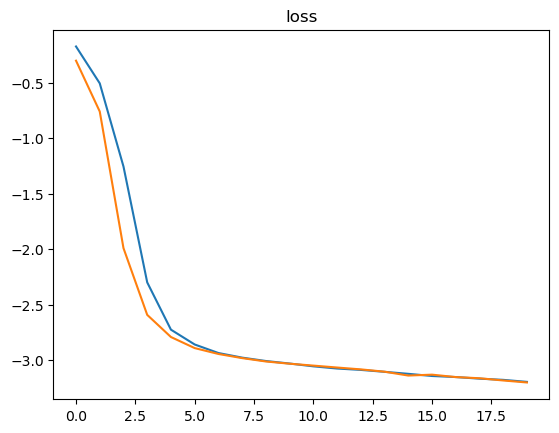

In [21]:
plt.plot(range(len(loss_vals_train)),loss_vals_train)
plt.plot(range(len(loss_vals_test)),loss_vals_test)
plt.title('loss')

In [166]:
### prøv trene lenge med validering og prøv med trunkert fordeling og skrive mer.

In [22]:
fashion_imgs_train = torch.load('MNIST_data/FashionMNIST/processed/training.pt')
fashion_imgs_test = torch.load('MNIST_data/FashionMNIST/processed/test.pt')


In [31]:
print(fashion_imgs_train[0].shape)

torch.Size([60000, 28, 28])


In [23]:
def gen_im_mix(model, im_size, nbh_size):
    m, n = nbh_size
    
    #new_im = np.zeros(im_size)
    #new_im = torch.zeros(im_size)
    #new_im = torch.full(im_size, 100.0)
    #new_im = torch.randint(low=50, high=150, size=im_size,dtype=torch.float)
    
    #new_im = torch.rand(im_size)-0.5 # prøv med 0.5
    #new_im = torch.full(im_size,0.5)
    pred_mu = np.zeros(im_size)
    pred_sigma2 = np.zeros(im_size)
    pred_mu2 = np.zeros(im_size)
    pred_sigma2_2 = np.zeros(im_size)
    pred_pi_mix = np.zeros(im_size)
    #neighborhood = train_img[i-m:i,j-n:j+n-1]
    #flat_n = neighborhood.flatten()
    new_im = fashion_imgs_test[0][2]/255 - 0.5
    #new_im = new_im.numpy()
    
    for i in range(10, new_im.shape[0]-m):
        for j in range(n, new_im.shape[1]-n):
            
            neighborhood = new_im[i-m:i,j-n:(j+n+1)]
            flat_n = neighborhood.flatten()
            
            dlt = n
            
            nbh_ij = flat_n[:-(dlt+1)]
            
            #print(nbh_ij.shape)
            output = model(torch.reshape(nbh_ij,(1,31))).detach().numpy()

            #pi_mix_output = output[0,2]
            #mu_output = output[0,0]
            #sigma2_output = output[0,1]
            #print(sigma2_output)
            pi_mix_output = output[0,4:]
            mu_output = output[0,0:2]
            sigma2_output = output[0,2:4]
            print(pi_mix_output)
            
            pi_mix_sample = np.random.choice(2, 1, p=pi_mix_output)[0]
            #pi_mix_sample = 0
            print(mu_output)
            #print(sigma2_output)
            #print(pi_mix_output)
            #sample = np.random.normal(output.detach().numpy()[0,0],np.sqrt(np.abs(output.detach().numpy()[0,1])))
            sample = np.random.normal(mu_output[pi_mix_sample], np.sqrt(sigma2_output[pi_mix_sample]))
            #sample = np.random.normal(mu_output, np.sqrt(sigma2_output))
            sample = np.clip(sample, -0.5, 0.5)
            #new_im[i,j] = sample
            #print(mu_output.dtype)
            #print(pi_mix_output.dtype)
            #new_im[i,j] = torch.from_numpy(mu_output)[pi_mix_sample]

            #pred_mu[i,j] = mu_output[pi_mix_sample]
            #pred_sigma2[i,j] = sigma2_output[pi_mix_sample]
            pred_mu[i,j] = mu_output[0]
            pred_sigma2[i,j] = sigma2_output[0]

            pred_mu2[i,j] = mu_output[1]
            pred_sigma2_2[i,j] = sigma2_output[1]
            pred_pi_mix[i,j] = pi_mix_output[0]
    
    #return new_im, pred_mu, pred_sigma2
    return new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix

In [25]:
new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix = gen_im_mix(mlp_mix, (28,28), (4,4))

[0.8715678  0.12843221]
[-0.49999997 -0.42200348]
[0.88002205 0.11997797]
[-0.49999997 -0.40866214]
[0.8257571  0.17424288]
[-0.49999994 -0.3782962 ]
[0.87865    0.12134993]
[-0.4999998  -0.33658886]
[0.69845146 0.30154857]
[-0.49999803 -0.27743438]
[0.02398152 0.9760184 ]
[-0.3968246   0.32266223]
[0.02011681 0.97988325]
[0.26355988 0.40902472]
[0.00994172 0.99005824]
[0.16699243 0.3810976 ]
[0.01447999 0.98551995]
[0.2086246 0.4155534]
[0.02384725 0.9761528 ]
[0.24276829 0.42770404]
[0.7660371  0.23396291]
[-0.49993542 -0.35799927]
[0.05470393 0.94529605]
[-0.25147223  0.41282827]
[0.02770218 0.9722978 ]
[0.15957683 0.384507  ]
[0.01011234 0.98988765]
[0.14647144 0.37640697]
[0.01230316 0.9876968 ]
[0.31091005 0.4427758 ]
[0.03752656 0.9624735 ]
[-0.45671946  0.15658975]
[0.79988533 0.20011465]
[-0.4999973  -0.32363117]
[0.9056565  0.09434348]
[-0.49999997 -0.41990256]
[0.8254317  0.17456833]
[-0.49999997 -0.42134455]
[0.85190094 0.14809908]
[-0.49999997 -0.42282516]
[0.8715678  0.12

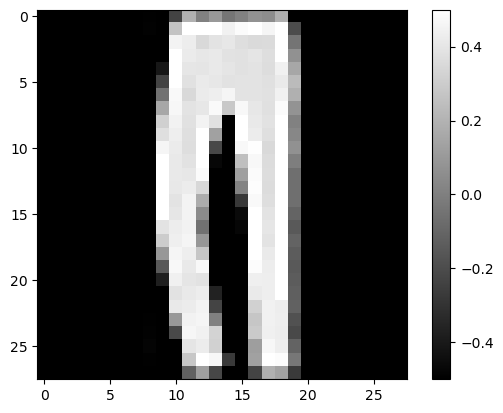

In [26]:
plt.imshow(new_im,cmap='gray')
plt.colorbar()

In [188]:
#plt.imshow(fashion_imgs[0][2],cmap='gray')
#plt.colorbar()

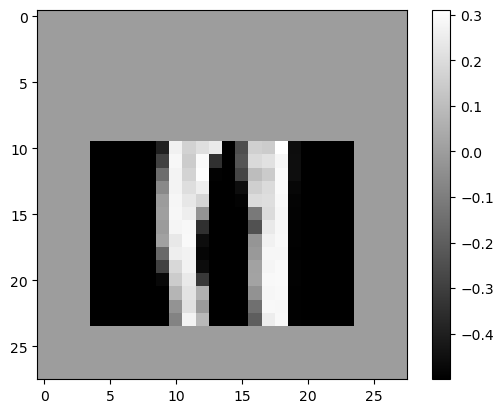

In [27]:
plt.imshow(pred_mu,cmap='gray')
plt.colorbar()

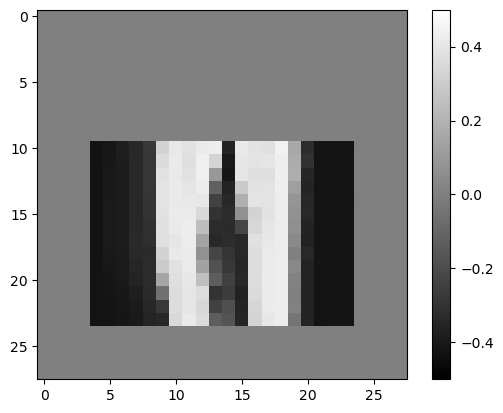

In [28]:
plt.imshow(pred_mu2,cmap='gray', vmax=0.5, vmin=-0.5)
plt.colorbar()

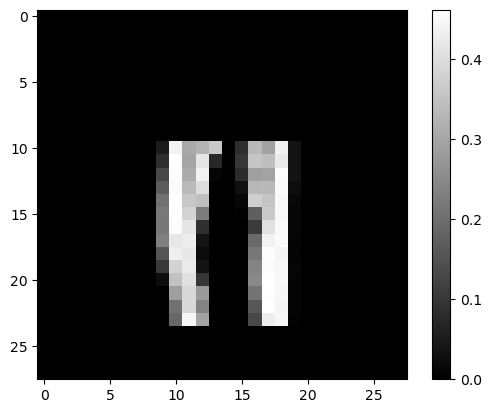

In [29]:
plt.imshow(np.sqrt(pred_sigma2),cmap='gray')#, vmax=0.2)
plt.colorbar()

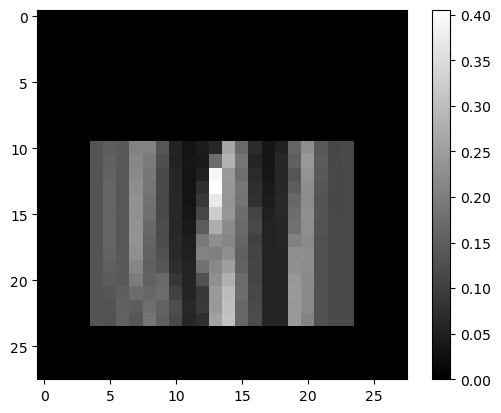

In [30]:
plt.imshow(np.sqrt(pred_sigma2_2),cmap='gray')
plt.colorbar()

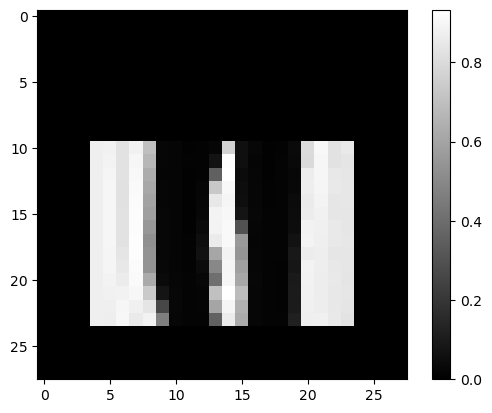

In [31]:
plt.imshow(pred_pi_mix,cmap='gray')
plt.colorbar()

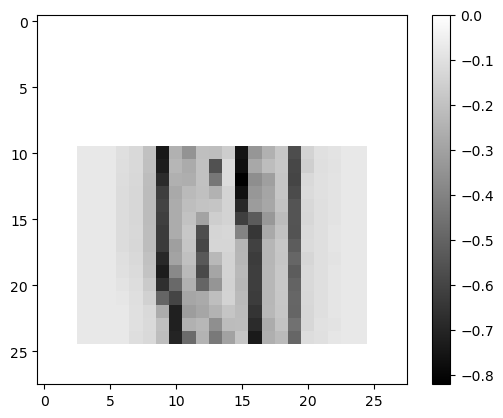

In [74]:
plt.imshow(pred_mu-pred_mu2,cmap='gray')
plt.colorbar()

In [ ]:
pyth

In [215]:
#### train on larger mini batch
#### test different learning rate
#### start with images and generate
#### skrive om NN, skrive om loss for andre foredlingfer og ta med modell og prarametre i likning

In [ ]:
y

In [32]:
from scipy.stats import truncnorm

/Users/Torgeir/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [99]:
# user input
myclip_a = -0.5
myclip_b = 0.5
my_mean = 0.5
my_std = 0.1

a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std


In [101]:
#plt.hist(truncnorm.rvs(a, b,loc= my_mean,scale=my_std, size=10990))

In [ ]:
myclip_a = -0.5
myclip_b = 0.5
my_mean = np.random.random((1,))
my_std = 0.1

In [59]:
def gen_im_mix_trunc(model, im_size, nbh_size):
    m, n = nbh_size
    
    #new_im = np.zeros(im_size)
    #new_im = torch.zeros(im_size)
    #new_im = torch.full(im_size, 100.0)
    #new_im = torch.randint(low=50, high=150, size=im_size,dtype=torch.float)
    
    #new_im = torch.rand(im_size)-0.5 # prøv med 0.5
    #new_im = torch.full(im_size,0.5)
    pred_mu = np.zeros(im_size)
    pred_sigma2 = np.zeros(im_size)
    pred_mu2 = np.zeros(im_size)
    pred_sigma2_2 = np.zeros(im_size)
    pred_pi_mix = np.zeros(im_size)
    #neighborhood = train_img[i-m:i,j-n:j+n-1]
    #flat_n = neighborhood.flatten()
    new_im = (fashion_imgs_test[0][0]/255 - 0.5)
    
    #new_im = new_im.numpy()
    
    for i in range(10, new_im.shape[0]-m):
        for j in range(n, new_im.shape[1]-n):
            
            neighborhood = new_im[i-m:i,j-n:(j+n+1)]
            flat_n = neighborhood.flatten()
            
            dlt = n
            
            nbh_ij = flat_n[:-(dlt+1)]
            
            #print(nbh_ij.shape)
            output = model(torch.reshape(nbh_ij,(1,31))).detach().numpy()

            #pi_mix_output = output[0,2]
            #mu_output = output[0,0]
            #sigma2_output = output[0,1]
            #print(sigma2_output)
            pi_mix_output = output[0,4:]
            mu_output = output[0,0:2]
            sigma2_output = output[0,2:4]
            print(pi_mix_output)
            
            pi_mix_sample = np.random.choice(2, 1, p=pi_mix_output)[0]
            #pi_mix_sample = 0
            print(mu_output)
            #print(sigma2_output)
            #print(pi_mix_output)
            #sample = np.random.normal(output.detach().numpy()[0,0],np.sqrt(np.abs(output.detach().numpy()[0,1])))
            #sample = np.random.normal(mu_output[pi_mix_sample], np.sqrt(sigma2_output[pi_mix_sample]))
            #sample = np.random.normal(mu_output, np.sqrt(sigma2_output))
            #sample = np.clip(sample, -0.5, 0.5)
            #new_im[i,j] = sample
            #print(mu_output.dtype)
            #print(pi_mix_output.dtype)
            #new_im[i,j] = torch.from_numpy(mu_output)[pi_mix_sample]
            myclip_a = -0.5
            myclip_b = 0.5
            my_mean = mu_output[pi_mix_sample]
            my_std = np.sqrt(sigma2_output[pi_mix_sample])

            a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
            sample_trunc = truncnorm.rvs(a, b,loc=my_mean,scale=my_std, size=1)
            new_im[i,j] = torch.from_numpy(sample_trunc)

            #pred_mu[i,j] = mu_output[pi_mix_sample]
            #pred_sigma2[i,j] = sigma2_output[pi_mix_sample]
            pred_mu[i,j] = mu_output[0]
            pred_sigma2[i,j] = sigma2_output[0]

            pred_mu2[i,j] = mu_output[1]
            pred_sigma2_2[i,j] = sigma2_output[1]
            pred_pi_mix[i,j] = pi_mix_output[0]
    
    #return new_im, pred_mu, pred_sigma2
    return new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix

In [57]:
new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix = gen_im_mix_trunc(mlp_mix, (28,28), (4,4))

[0.9284971  0.07150289]
[-0.49999958 -0.43422037]
[0.10664974 0.89335024]
[-0.49949977 -0.03704008]
[0.01939933 0.98060066]
[-0.49218476  0.24604398]
[0.03587325 0.9641267 ]
[-0.4996556  -0.07641041]
[0.29582    0.70417994]
[-0.4997414 -0.2826434]
[0.01099633 0.9890036 ]
[-0.0888007   0.40492815]
[0.06370911 0.93629086]
[-0.48289225 -0.10643339]
[0.01131314 0.9886869 ]
[0.06840158 0.36363244]
[0.02388039 0.97611964]
[0.00141907 0.31521118]
[0.02401051 0.97598946]
[0.02707076 0.28930312]
[0.01236776 0.9876323 ]
[0.04264921 0.32033354]
[0.01840137 0.98159856]
[0.04051369 0.359245  ]
[0.26285666 0.73714334]
[-0.49277315  0.0195635 ]
[0.70849824 0.29150173]
[-0.4999965  -0.35267547]
[0.02078464 0.9792154 ]
[-0.48980448  0.12966996]
[0.3362168 0.6637832]
[-0.4999744 -0.1544536]
[0.10149556 0.89850444]
[-0.4996829 -0.0737561]
[0.495279   0.50472105]
[-0.4999968 -0.3166931]
[0.00929732 0.9907026 ]
[-0.47652388  0.26972812]
[0.04246924 0.95753074]
[-0.4839597   0.00912172]
[0.00829684 0.991703

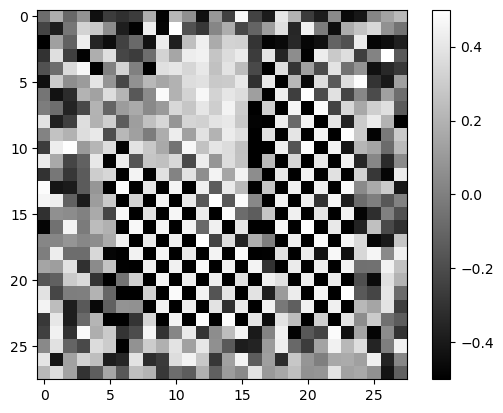

In [58]:
plt.imshow(new_im,cmap='gray')
plt.colorbar()

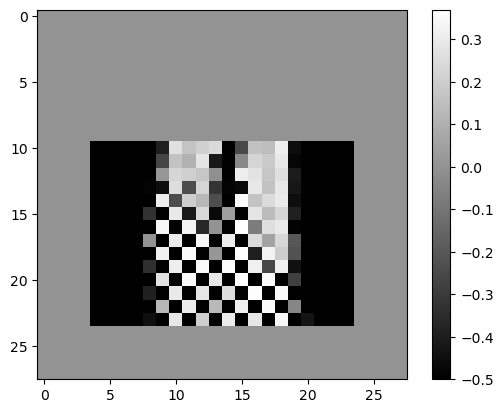

In [37]:
plt.imshow(pred_mu,cmap='gray')
plt.colorbar()